In [23]:
import netCDF4, arcpy, glob

In [63]:
tc_ds = r"Z:\PhD_Datasets&Analysis\Info_Inputs\TerraClimate"
bands_gee = ["pr", "pet", "ro"] # band names in gee
tc_vars = ["ppt", "pet", "q"] # variable names according to TerraClimate
arcpy.env.overwriteOutput = True

In [ ]:
inNetCDF = tc_ds + "//TerraClimate_ppt_1980.nc"
nc = netCDF4.Dataset(inNetCDF, mode="r") # Read the data
nc_FP = arcpy.NetCDFFileProperties(inNetCDF)

In [11]:
# Variables in the data
nc.variables.keys()

dict_keys(['lat', 'lon', 'time', 'crs', 'ppt'])

In [4]:
mth_raster = nc.variables[vars[0]][0][:][:]

In [39]:
my_raster = arcpy.Raster(inNetCDF, True)

In [43]:
## Check if it is multidimensional raster
my_raster.isMultidimensional

True

In [44]:
## Return the multidimensional information
my_raster.mdinfo

'{"variables":[{"name":"ppt","description":"Accumulated Precipitation","unit":"mm","attributes":{"long_name":"precipitation_amount","standard_name":"precipitation_amount","dimensions":"lon lat time","coordinate_system":"WGS84,EPSG:4326","_Unsigned":"false","scale_factor":0.10000000000000001,"add_offset":0,"_FillValue":-2147483648},"dimensions":[{"name":"StdTime","field":"StdTime","description":"days since 1900-01-01","unit":"ISO8601","interval":1,"hasRegularIntervals":true,"intervalUnit":"Months","extent":["1980-01-01T00:00:00","1980-12-01T00:00:00"],"hasRanges":false,"values":["1980-01-01T00:00:00","1980-02-01T00:00:00","1980-03-01T00:00:00","1980-04-01T00:00:00","1980-05-01T00:00:00","1980-06-01T00:00:00","1980-07-01T00:00:00","1980-08-01T00:00:00","1980-09-01T00:00:00","1980-10-01T00:00:00","1980-11-01T00:00:00","1980-12-01T00:00:00"]}]}],"layout":1}'

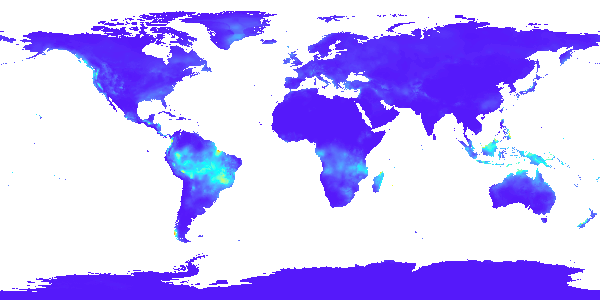

In [40]:
my_raster

In [37]:
## Return the list of band names
my_raster.bandNames

['Band_1']

In [ ]:
## Return the list of variable names and their dimensions
my_raster.variables

['ppt(StdTime=12)']

In [47]:
## Get the dimension names of the "ppt" variable 
my_raster.getDimensionNames("ppt")

['StdTime']

In [54]:
## Get the time dimension values for the "ppt" variable
dimension_values = my_raster.getDimensionValues("ppt", "StdTime")
dimension_values

['1980-01-01T00:00:00+00:00',
 '1980-02-01T00:00:00+00:00',
 '1980-03-01T00:00:00+00:00',
 '1980-04-01T00:00:00+00:00',
 '1980-05-01T00:00:00+00:00',
 '1980-06-01T00:00:00+00:00',
 '1980-07-01T00:00:00+00:00',
 '1980-08-01T00:00:00+00:00',
 '1980-09-01T00:00:00+00:00',
 '1980-10-01T00:00:00+00:00',
 '1980-11-01T00:00:00+00:00',
 '1980-12-01T00:00:00+00:00']

In [73]:
raster_to_use = "ppt_1980_1"
arcpy.MakeNetCDFRasterLayer_md(inNetCDF, tc_vars[0], "lon", "lat", raster_to_use, "", [["time", dimension_values[0]]], "BY_VALUE")

<Result 'ppt_1980_1'>

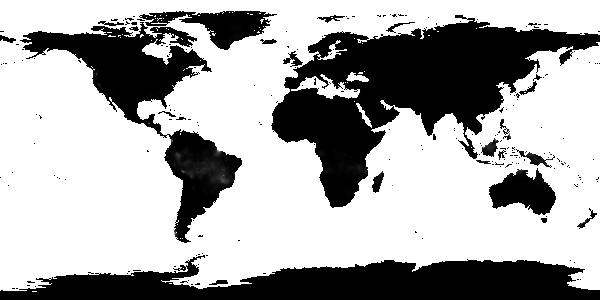

In [75]:
prueba = arcpy.Raster(raster_to_use) ** 2
prueba

In [17]:
nc_FP.getDimensions()

['crs', 'lat', 'lon', 'time']

In [18]:
nc_FP.getDimensionSize("time")

12

In [51]:
nc_FP.getDimensionValue("time", 0)

'1/1/1980'

In [77]:
dimension_value = nc_FP.getDimensionValue("time", 0) # Acá se debe usar el número del mes

In [78]:
aster_to_use = "ppt_1980_1"
arcpy.MakeNetCDFRasterLayer_md(inNetCDF, tc_vars[0], "lon", "lat", raster_to_use, "", [["time", dimension_value]], "BY_VALUE")

<Result 'ppt_1980_1'>

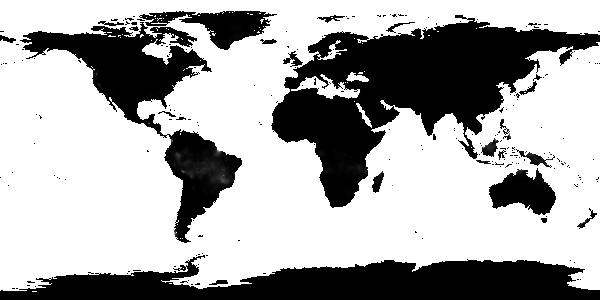

In [79]:
prueba = arcpy.Raster(raster_to_use) ** 2
prueba

In [22]:
nc_FP.getDimensionValue("time", 1)

'2/1/1980'

In [27]:
cdfList = glob.glob(tc_ds + "//*_ppt_*.nc")
cdfList

['Z:\\PhD_Datasets&Analysis\\Info_Inputs\\TerraClimate\\TerraClimate_ppt_1958.nc',
 'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\TerraClimate\\TerraClimate_ppt_1959.nc',
 'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\TerraClimate\\TerraClimate_ppt_1960.nc',
 'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\TerraClimate\\TerraClimate_ppt_1961.nc',
 'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\TerraClimate\\TerraClimate_ppt_1962.nc',
 'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\TerraClimate\\TerraClimate_ppt_1963.nc',
 'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\TerraClimate\\TerraClimate_ppt_1964.nc',
 'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\TerraClimate\\TerraClimate_ppt_1965.nc',
 'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\TerraClimate\\TerraClimate_ppt_1966.nc',
 'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\TerraClimate\\TerraClimate_ppt_1967.nc',
 'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\TerraClimate\\TerraClimate_ppt_1968.nc',
 'Z:\\PhD_Datasets&Analysis\\Info_Inputs\\TerraClimate\\TerraClimate_ppt_1969.nc',
 'Z: